# Teste do Algoritmo COF
Teste dos algoritmos de detecção de anomalias para comparação e seleção dos integrantes do aplicativo

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.model_selection import GridSearchCV
from pyod.utils.data import evaluate_print
import matplotlib.pyplot as plt

tabelafinal = pd.DataFrame(columns=['algoritmo','contaminacao','acuracia','precisao','recall','f1','fn','fp','tp'])
print(tabelafinal)
 
def avalia(clf_name,Y,y_train_scores,y_train_pred):
    # Avalia e imprime os resultados
    print("Avaliação do modelo "+clf_name+":")
    evaluate_print(clf_name, Y, y_train_scores)
    tn, fp, fn, tp = confusion_matrix(Y,y_train_pred).ravel()
    print('Acurácia='+str(accuracy_score(Y,y_train_pred)*100))   
    print('Precisão='+str(precision_score(Y,y_train_pred)*100))
    print('Recall='+str(recall_score(Y,y_train_pred)*100))
    print('Falso Positivo='+str(fp))
    print('Falso Negativo='+str(fn))
    print('F1-score='+str(f1_score(Y,y_train_pred)*100))
    print('ROC='+str(roc_auc_score(Y,y_train_scores)))

def gera_matriz_de_confusao(Y,y_train_pred,clf_name):
    cm = confusion_matrix(Y,y_train_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal','Anomalia'])
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set(title='Matriz de Confusão do '+clf_name,xlabel='Valores preditos', ylabel='Valores reais')
    plt.show()
    
def grava_avaliacao(clf_name,Y,y_train_scores,y_train_pred,contamination):
    # Grava os resultados da avaliação na tabela final
    tn, fp, fn, tp = confusion_matrix(Y,y_train_pred).ravel()
    ac=("{:.2f}".format(round(accuracy_score(Y,y_train_pred)*100,2))).replace(".", ",")
    print('Acurácia='+ac)   
    pc=("{:.2f}".format(round(precision_score(Y,y_train_pred)*100,2))).replace(".", ",")
    print('Precisão='+pc)
    rc=("{:.2f}".format(round(recall_score(Y,y_train_pred)*100,2))).replace(".", ",")
    print('Recall='+rc)
    f1=("{:.2f}".format(round(f1_score(Y,y_train_pred)*100,2))).replace(".", ",")
    print('F1='+f1)
    print('Falso Negativo='+str(fn))
    print('Falso Positivo='+str(fp))
    print('Verdadeiro Positivo='+str(tp))
    cont=str(round(contamination,2)).replace(".",",")
    tabelafinal.loc[len(tabelafinal.index)] = [clf_name,cont,ac,pc,rc,f1,fn,fp,tp] 
      

Empty DataFrame
Columns: [algoritmo, contaminacao, acuracia, precisao, recall, f1, fn, fp, tp]
Index: []


# Recuperação dos dados a serem utilizados na avaliação
Leitura do arquivo gerado para o material de catmat_id= 445485 -> Descrição:'ÁGUA MINERAL NATURAL, TIPO SEM GÁS MATERIAL EMBALAGEM PLÁSTICO TIPO EMBALAGEM RETORNÁVEL'.

In [2]:
import os
import pandas as pd
def load_itens(path):
    csv_path = os.path.join(path,"445485.csv")
    return pd.read_csv(csv_path)

df=load_itens(".")
## Retira os campos que não serão utilizados no treinamento
df = df.drop(['licitacao_contrato'],axis=1)
df = df.drop(['id'],axis=1)
df = df.drop(['data'],axis=1)
df = df.drop(['catmat_id'],axis=1)
df = df.drop(['unidade'],axis=1)
df = df.drop(['valor_total'],axis=1)
df = df.drop(['municipio_uasg'],axis=1)
df = df.drop(['municipio_fornecedor'],axis=1)
print(df)

     quantidade  valor_unitario  distancia_uasg_fornecedor  anomalia
0           420           12.00                    935.371         0
1         28000            5.88                      0.000         0
2          2100            5.09                      0.000         0
3           360            7.70                    172.788         0
4           120            7.70                    172.788         0
..          ...             ...                        ...       ...
725        5000           10.45                    398.772         0
726        4000           13.45                    398.772         0
727        1440           11.37                      0.000         0
728        1440           10.58                      0.000         0
729          10           20.00                      0.000         0

[730 rows x 4 columns]


# Separação do Label dos dados

In [3]:
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]
print(X)
print(Y)

     quantidade  valor_unitario  distancia_uasg_fornecedor
0           420           12.00                    935.371
1         28000            5.88                      0.000
2          2100            5.09                      0.000
3           360            7.70                    172.788
4           120            7.70                    172.788
..          ...             ...                        ...
725        5000           10.45                    398.772
726        4000           13.45                    398.772
727        1440           11.37                      0.000
728        1440           10.58                      0.000
729          10           20.00                      0.000

[730 rows x 3 columns]
0      0
1      0
2      0
3      0
4      0
      ..
725    0
726    0
727    0
728    0
729    0
Name: anomalia, Length: 730, dtype: int64


# Pré-processamento normalização dos dados min-max e robust

In [4]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import numpy as np

# Cria uma instância do RobustScaler
robust_scaler = RobustScaler()

# Ajusta e transforma os dados com o RobustScaler
X_robust = robust_scaler.fit_transform(X)

# Cria uma instância do MinMaxScaler
minmax_scaler = MinMaxScaler()

# Ajusta e transforma os dados com o MinMaxScaler
X_minmax =  minmax_scaler.fit_transform(X)
X_minmaxrobust =  minmax_scaler.fit_transform(X_robust)



# COF

In [5]:
## class pyod.models.cof.COF(contamination=0.1, n_neighbors=20, method='fast')
#Parameters
#contamination float in (0., 0.5), optional (default=0.1)
# The amount of contamination of the data set, i.e. the proportion of outliers in the data set. Used when fitting to define the threshold on the decision function.
# n_neighborsint, optional (default=20)
# Number of neighbors to use by default for k neighbors queries. Note that n_neighbors should be less than the number of samples. If n_neighbors is larger than the number of samples provided, all samples will be used.
# method string, optional (default=’fast’)
#Valid values for method are:
# ‘fast’ Fast COF, computes the full pairwise distance matrix up front.
# ‘memory’ Memory-efficient COF, computes pairwise distances only when needed at the cost of computational speed

from pyod.models.cof import COF
from sklearn.model_selection import GridSearchCV

# Uso do constructor para criar um classifier.
clf = COF()
clf_name='COF'

parametros = {'contamination': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15],
              'n_neighbors':[5, 10, 15, 20, 25, 30],
              'method':['fast','memory']}

grid = GridSearchCV(estimator = clf,          
                param_grid = parametros,  
                scoring = 'recall',           
                cv = 10) 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\skle

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, wher

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\bas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.appe

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, wher

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: Us

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_ind

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_inde

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\bas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-package

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\bas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_nei

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warni

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division`

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_inde

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_inde

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\nump

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\bas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-package

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\bas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.appe

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\bas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.appe

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

Best Score:  0.7
Best Params:  {'contamination': 0.14, 'method': 'fast', 'n_neighbors': 30}
Avaliação do modelo COF:
COF ROC:0.9639, precision @ rank n:0.5238
Acurácia=88.9041095890411
Precisão=19.387755102040817
Recall=90.47619047619048
Falso Positivo=79
Falso Negativo=2
F1-score=31.9327731092437
ROC=0.9639331049768286


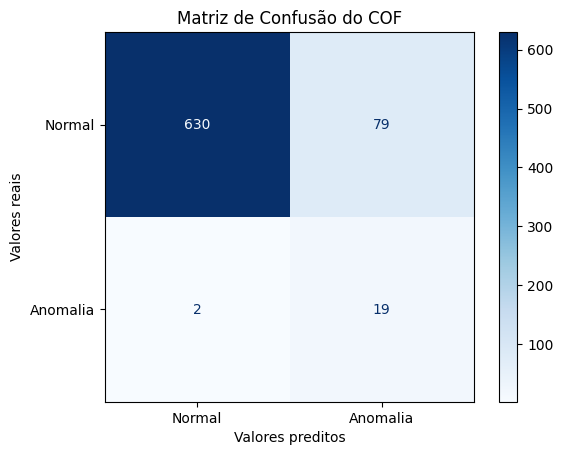

Acurácia=88,90
Precisão=19,39
Recall=90,48
F1=31,93
Falso Negativo=2
Falso Positivo=79
Verdadeiro Positivo=19


In [6]:
# Teste com as duas normalizações

grid_result = grid.fit(X_minmaxrobust, Y)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

contamination=grid_result.best_params_['contamination']

funcao=clf_name+'(**grid.best_params_)'
clf = eval(funcao)
clf.fit(X_minmaxrobust)

avalia(clf_name,Y,clf.decision_scores_,clf.labels_)
gera_matriz_de_confusao(Y,clf.labels_ ,clf_name)
grava_avaliacao(clf_name+' Robusta e minmax',Y,clf.decision_scores_,clf.labels_,round(contamination,2))

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\skle

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\bas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-package

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\bas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.appe

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_inde

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\bas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_inde

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\nump

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\bas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encoun

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_ind

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\bas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.appe

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  c

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\bas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.appe

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\bas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encoun

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\bas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.appe

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_inde

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\bas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_ind

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_inde

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\bas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, wher

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_inde

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\bas

Best Score:  0.7
Best Params:  {'contamination': 0.14, 'method': 'fast', 'n_neighbors': 30}
Avaliação do modelo COF:
COF ROC:0.9639, precision @ rank n:0.5238
Acurácia=88.9041095890411
Precisão=19.387755102040817
Recall=90.47619047619048
Falso Positivo=79
Falso Negativo=2
F1-score=31.9327731092437
ROC=0.9639331049768286


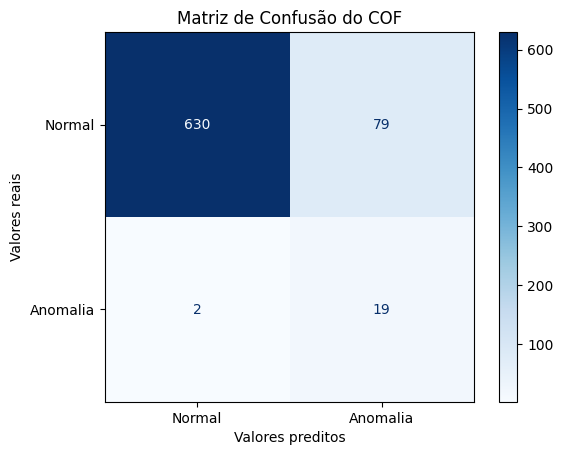

Acurácia=88,90
Precisão=19,39
Recall=90,48
F1=31,93
Falso Negativo=2
Falso Positivo=79
Verdadeiro Positivo=19


In [7]:
# Teste com só MinMax

grid_result = grid.fit(X_minmax, Y)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

contamination=grid_result.best_params_['contamination']

funcao=clf_name+'(**grid.best_params_)'
clf = eval(funcao)
clf.fit(X_minmax)

avalia(clf_name,Y,clf.decision_scores_,clf.labels_)
gera_matriz_de_confusao(Y,clf.labels_ ,clf_name)
grava_avaliacao(clf_name+' minmax',Y,clf.decision_scores_,clf.labels_,round(contamination,2))

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\skle

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warni

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: Us

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\bas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y sh

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, wher

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y sh

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.c

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, wher

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y sh

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y sh

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y sh

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

Best Score:  0.8
Best Params:  {'contamination': 0.05, 'method': 'fast', 'n_neighbors': 25}
Avaliação do modelo COF:
COF ROC:0.9401, precision @ rank n:0.2857
Acurácia=95.06849315068493
Precisão=29.72972972972973
Recall=52.38095238095239
Falso Positivo=26
Falso Negativo=10
F1-score=37.931034482758626
ROC=0.9400899993283631


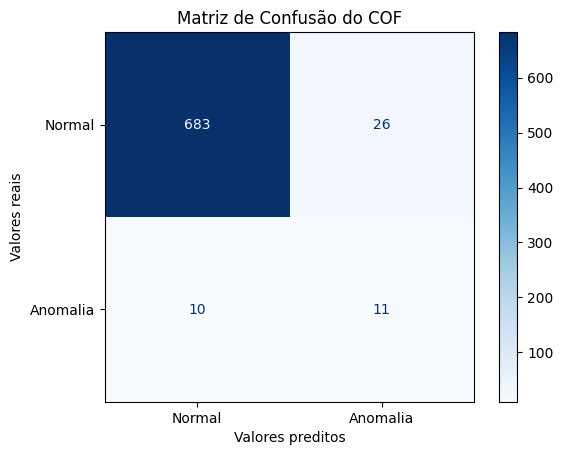

Acurácia=95,07
Precisão=29,73
Recall=52,38
F1=37,93
Falso Negativo=10
Falso Positivo=26
Verdadeiro Positivo=11


In [8]:
# Teste com só Robusta

grid_result = grid.fit(X_robust, Y)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

contamination=grid_result.best_params_['contamination']

funcao=clf_name+'(**grid.best_params_)'
clf = eval(funcao)
clf.fit(X_robust)

avalia(clf_name,Y,clf.decision_scores_,clf.labels_)
gera_matriz_de_confusao(Y,clf.labels_ ,clf_name)
grava_avaliacao(clf_name+' Robusta',Y,clf.decision_scores_,clf.labels_,round(contamination,2))

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\skle

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selec

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\bas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\nump

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, wher

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, wher

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: invalid value encountered in double_scalars
  cof_.append((ac_dist[_g] * self.n_neighbors_) /
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:209: RuntimeWarning: 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-t

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: invalid value encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\cof.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  cof_[_g] = (ac_dist[_g] * self.n_neighbors_) / np.sum(ac_dist[sbn_path_index[_g]])
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(0, slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\met

Best Score:  0.8
Best Params:  {'contamination': 0.05, 'method': 'fast', 'n_neighbors': 25}
Avaliação do modelo COF:
COF ROC:0.8978, precision @ rank n:0.2857
Acurácia=93.97260273972603
Precisão=18.91891891891892
Recall=33.33333333333333
Falso Positivo=30
Falso Negativo=14
F1-score=24.137931034482758
ROC=0.8978440459399557


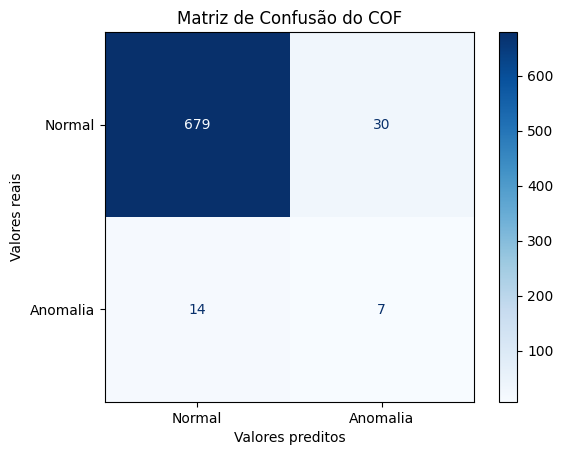

Acurácia=93,97
Precisão=18,92
Recall=33,33
F1=24,14
Falso Negativo=14
Falso Positivo=30
Verdadeiro Positivo=7


In [9]:
# Teste sem Normalização

grid_result = grid.fit(X, Y)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

contamination=grid_result.best_params_['contamination']

funcao=clf_name+'(**grid.best_params_)'
clf = eval(funcao)
clf.fit(X)

avalia(clf_name,Y,clf.decision_scores_,clf.labels_)
gera_matriz_de_confusao(Y,clf.labels_ ,clf_name)
grava_avaliacao(clf_name,Y,clf.decision_scores_,clf.labels_,round(contamination,2))

# Imprime a tabela final de avaliação

In [10]:
tabelafinal.sort_values("fn", axis = 0, ascending = True,
                 inplace = True, na_position ='last')
print(tabelafinal)

              algoritmo contaminacao acuracia precisao recall     f1  fn  fp  \
0  COF Robusta e minmax         0,14    88,90    19,39  90,48  31,93   2  79   
1            COF minmax         0,14    88,90    19,39  90,48  31,93   2  79   
2           COF Robusta         0,05    95,07    29,73  52,38  37,93  10  26   
3                   COF         0,05    93,97    18,92  33,33  24,14  14  30   

   tp  
0  19  
1  19  
2  11  
3   7  
